In [1]:
from datetime import datetime
from time import time
from itertools import combinations
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering,spectral_clustering
import scipy.cluster.hierarchy as sch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

In [2]:
global brands_list
global brand_followers
global condnsd_dist_mat
global dist_mat
global Z
global clusters
global n_brands
global n_clusters

In [3]:
#parameters
n_brands = 100
n_clusters = 8

In [4]:
def check_data_file():
    import os.path
    if os.path.exists('brand_followers.tsv'):
        #fix brand followers - Do not run more than more
        out_file = open("brand_followers_fixed.tsv","w")
        with open('brand_followers.tsv','r') as data_file:
            data = data_file.read()
            data = data.replace('1114073faithhill','1114073\nfaithhill')
            out_file.write(data)
        out_file.close()
        os.remove('brand_followers.tsv')
        return True
    elif os.path.exists('brand_followers_fixed.tsv'):
        return True
    return False

In [5]:
def load_data(max_row_count=1404):
    global brands_list
    global brand_followers
    global n_brands
    
    start = datetime.now()    
    
    brand_followers = {}
    brands_list = []
    
    row_id = 0
    skipped = 0
    with open('brand_followers_fixed.tsv') as data_file:
        for row in data_file:
            row_id += 1
            followers = row.split()
            brand = followers.pop(0)
            if len(followers) > 50:
                brand_followers[brand] = set([int(x) for x in followers])
                brands_list.append(brand)
            else:
                skipped +=1
            if row_id % 500 == 0:
                print( 'Loaded brand', row_id, '-', brand, 'with',len(followers),'followers.')
            if row_id == max_row_count:
                stop = datetime.now()
                print('Loaded',max_row_count,', Skipped',skipped, 'rows in time',stop-start)
                n_brands = max_row_count-skipped
                break
    return

In [6]:
def compute_distance_matrix():
    global brands_list
    global brand_followers
    global condnsd_dist_mat
    global dist_mat
    global n_brands
    
    dist_mat = np.zeros((n_brands,n_brands))
    start = datetime.now()
    condnsd_dist_mat = []
    edges = 0
    for tuple_pair in combinations(enumerate(brands_list),2):
        #tuple_pair = (b1_idx, b1_name)(b2_idx, b2_name)
        b1 = brand_followers[tuple_pair[0][1]]
        b2 = brand_followers[tuple_pair[1][1]]
        
        #Jaccard Similarity Measure
        common_connections = len(b1.intersection(b2))
        total_connections = len(b1) + len(b2) - common_connections #More efficient than set(b1).union(b2)
        weight = common_connections/total_connections

        #Condensed Distance Matrix
        condnsd_dist_mat.append(1.0 - weight)
        
        #Symmetrix Distance Matrix
        dist_mat[tuple_pair[0][0] , tuple_pair[1][0]] = dist_mat[tuple_pair[1][0] , tuple_pair[0][0]] = 1.0 - weight
        
        edges += 1
        if edges%80000 == 0:
            print(edges, 'edges loaded.')
        
    stop = datetime.now()
    
    print('Created',n_brands,'x',n_brands,'Distance Matrix in time',stop-start)
    brand_followers = {}
    return

In [7]:
def create_clusters():
    global condnsd_dist_mat
    global brands_list
    global Z
    global dist_mat
    global n_clusters
    
    start = datetime.now()
    
    #Sample code for Agglomerative Clustering
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete').fit(dist_mat)
    print('Agglomerative Clustering')
    get_clusters(clustering.labels_, visualize=True)
    
    print('Hierarchical Clustering')
    for method in ['complete']: #['single', 'complete', 'average', 'weighted']:

        print('Linkage Method:',method)
        
        Z = sch.linkage(condnsd_dist_mat, method=method)
        
        #Threshold = 0.99999999
        labels = sch.fcluster(Z,0.99999999)
        get_clusters(labels)
        
        plt.clf()
        print('Num Clusters:',max(labels))
        if n_brands > 1000:
            fig = plt.figure(figsize=(100,100))
        else:
            fig = plt.figure()
        dd = sch.dendrogram(Z, labels=brands_list,orientation='right')
        plt.savefig('figures/{}.pdf'.format(method))
        
        print('Elapsed time',datetime.now()-start)
        
    stop = datetime.now()
    print('Clustering completed in time',stop-start)
    get_scores()

In [8]:
def get_clusters(cluster_labels, output='label', visualize=False, cluster_distribution=False):
    global clusters
    global n_brands
    
    clusters = {}
    start = min(cluster_labels)
    stop = max(cluster_labels)
    
    #Initialize
    for i in range(start,stop+1):
        clusters[i] = []    
    
    #Cluster Dictionary
    for i in range(n_brands):
        clusters[cluster_labels[i]].append(brands_list[i])
    
    #Printing desired output
    if output=='label':
        print('Printing by labels...')
        for i in range(start,stop+1):
            print (i,':',clusters[i])
    elif output=='size':
        print('Printing by size...')
        for key in sorted(clusters, reverse=True, key=lambda k: len(clusters[k])):
            print (len(clusters[key]),'(',key,'):',clusters[key])

    #Visualize
    if visualize:
        visualize_cluster(cluster_labels)
    
    #Plot Cluster Size Distribution
    if cluster_distribution:
        plot_cluster_size()
        
    

In [21]:
def visualize_cluster(cluster_labels):
    from sklearn.manifold import MDS
    global dist_mat
    global brands_list
    global n_brands
    
    if min(cluster_labels) == 0:
        num_clusters = max(cluster_labels) + 1
    else:
        num_clusters = max(cluster_labels)
        

    print('Num Clusters:',num_clusters)
    
    if n_brands > 1000:
        fig = plt.figure(figsize=(100,100))
    else:
        fig = plt.figure()
    fig, ax = plt.subplots(figsize=(15,15))
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1, num_clusters))
    colors_map = []
    for i in range(n_brands):
        colors_map.append(colors[cluster_labels[i]])
        
        
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(1-dist_mat)  # shape (n_components, n_samples)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    for i in range(n_brands):
        ax.scatter(xs[i],ys[i],color=colors_map[i])
        ax.text(xs[i],ys[i],brands_list[i])
    plt.savefig('figures/{}.png'.format('Clusters'))

In [10]:
def plot_cluster_size():
    global clusters
    cluster_size_count = []
    for cluster_id in clusters:
        cluster_size_count.append(len(clusters[cluster_id]))
    #print (cluster_size_count)
    plt.hist(cluster_size_count, bins = range(max(cluster_size_count)+1))
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    plt.title('Cluster Size Distribution')
    plt.savefig('figures/{}.png'.format('Cluster Size Distribution'))

In [11]:
def get_scores():
    global dist_mat
    global Z
    fig = plt.figure()
    print('Threshold, Silhoutte Score')
    for i in range(60,100,5):
        threshold = i/100.0
        z = sch.fcluster(Z,threshold)
        #print(z)
        score = metrics.silhouette_score(np.asarray(dist_mat), z)
        plt.scatter(threshold,score)
        plt.plot(threshold,score, marker='o')
        print(threshold,score)
        #print ('Silhoutte Coefficient:',score)
    plt.savefig('figures/{}.png'.format('Silhoutte Coefficient'))

In [12]:
def spectral_cluster(num_clusters):
    global dist_mat
    for eigen_solver in ['arpack']: #, 'lobpcg']:
        for assign_labels in ['kmeans', 'discretize']:
            print(eigen_solver,assign_labels)
            model = SpectralClustering(n_clusters=num_clusters,
                                       affinity='precomputed',
                                       eigen_solver=eigen_solver,
                                       assign_labels=assign_labels
                                       ).fit(dist_mat)
            labels = model.labels_
            
            get_clusters(labels)
    labels = spectral_clustering(1-dist_mat, n_clusters=num_clusters,
                                 eigen_solver="arpack")
    print(labels)
    get_clusters(labels)

In [13]:
if check_data_file():
    load_data(n_brands)    
    compute_distance_matrix()

Loaded 100 , Skipped 0 rows in time 0:00:06.517086
Created 100 x 100 Distance Matrix in time 0:00:04.025647


Agglomerative Clustering
Printing by labels...
0 : ['3mnews', '7daysinutopia', '7up', 'acer', 'acne_free_skin', 'act', 'acti_pr', 'activia', 'aidstillreqd', 'airheadscandy', 'airwickmexico', 'alecjones33', 'alissacohen', 'ambipurindia', 'amerapparelsale', 'andessn', 'angelicastiffy', 'aphroditegy', 'april_rain', 'aprioridiamonds', 'aquafina', 'arizonadot', 'asaideiralounge', 'asus', 'australiangold_', 'azzaro', 'babiesruscanada', 'babyblanketgift', 'bachremedies', 'bahlsenbiscuits', 'ballaformen', 'bambinomio', 'bar35', 'barilla', 'barq_photos', 'basic4veg']
1 : ['abreva', 'allegraotc', 'alphahydrox', 'always', 'american_girl', 'ancientminerals', 'antimonkeybutt', 'artisanafoods', 'athenos', 'babobotanicals', 'baby_magic', 'babyganics']
2 : ['5hourenergy', '8oclockcoffee', '8thcontinentsoy', 'acneorg', 'amanabrand', 'ampenergy', 'aquaphorus', 'balancebar', 'bananaboat', 'barbarasbakery', 'barbasolshave', 'barkeeperfriend', 'barsfoods']
3 : ['20thcenturyfox', 'adidas', 'armani', 'att', 

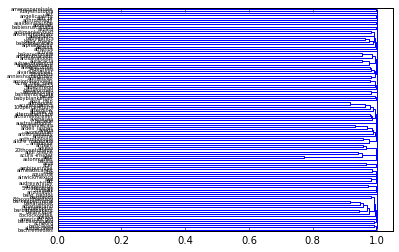

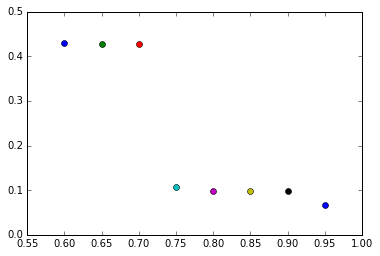

In [22]:
create_clusters()    

In [ ]:
#get_scores() #Only for Hierarchical

In [ ]:
spectral_cluster(n_clusters)